In [14]:
from scipy import misc
import numpy as np
from scipy.fftpack import dct, idct
from skimage.color import rgb2lab, lab2rgb
import math
import matplotlib.pyplot as plt
from quant_tables import *
import utils
import JPEG
import bitarray
import gzip
import os

from scipy.signal import decimate,resample
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
calBlue = misc.imread('images/calBlue.tiff')
Marconi = misc.imread('images/Marconi.tiff')
createrLake = misc.imread('images/createrLake.tiff')
Isee = misc.imread('images/Isee.tiff')
pauly = misc.imread('images/pauly.tiff')

#Downsampled examples
calBlue_s = misc.imread('images/small/calBlue.tiff')
Marconi_s = misc.imread('images/small/Marconi.tiff')
createrLake_s = misc.imread('images/small/createrLake.tiff')
Isee_s = misc.imread('images/small/Isee.tiff')
pauly_s = misc.imread('images/small/pauly.tiff')

In [16]:
def zero_pad_image(V):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    rows, cols = roundup(V.shape[0]), roundup(V.shape[1])
    zeros = np.zeros((rows, cols, 3))
    zeros[:V.shape[0], :V.shape[1], :] = V
    return zeros

def reflect_pad_image(V):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    rows, cols = roundup(V.shape[0]) - V.shape[0], roundup(V.shape[1]) - V.shape[1]
    shape = ((0,rows), (0,cols), (0,0))
    return np.pad(V,shape,mode = "reflect")

def constant_pad_image(V):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    rows, cols = roundup(V.shape[0]) - V.shape[0], roundup(V.shape[1]) - V.shape[1]
    shape = ((0,rows), (0,cols), (0,0))
    return np.pad(V,shape,mode = "edge")

In [269]:
#Zero_pad
O = reflect_pad_image(createrLake)
#Conver to YCbCr
O = rgb2lab(O)
#Add offset
O[:,:,[1,2]] += 128

In [273]:
def block_image(V):
    l = []
    for i in np.arange(0,V.shape[0], 8):
        for j in np.arange(0, V.shape[1], 8):
            l.append(V[i:i+8, j:j+8, :])
    return np.array(l)

def unblock_image(X,height, width):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    height, width = roundup(height), roundup(width)
    result = np.zeros((height,width,3))
    n = 0
    for i in np.arange(0,height, 8):
        for j in np.arange(0, width, 8):
            result[i:i+8,j:j+8,:] = X[n]
            n += 1
    return result
    
#Blocked
blocked_image = block_image(O)
temp = unblock_image(blocked_image,O.shape[0],O.shape[1])
print(np.array_equal(O,temp))

def dct_2d(X):
    return dct(dct(X, axis=1), axis=2)

def dct_all(X):
    blocks = block_image(X)
    return dct_2d(blocks)

def idct_2d(X):
    return idct(idct(X, axis=1), axis=2)*1.0/(256)

#Blocks and applies DCT
blocked_image = block_image(O)
O_dct = dct_2d(blocked_image)
temp2 = idct_2d(O_dct)
print(temp2[0,0])
print(blocked_image[0,0])

True
[[  78.59249985  130.81695644  112.53008941]
 [  79.67856325  130.80053558  112.57181228]
 [  80.76159204  130.78452755  112.61287949]
 [  80.76159204  130.78452755  112.61287949]
 [  80.76159204  130.78452755  112.61287949]
 [  81.12193587  130.7792804   112.62642605]
 [  81.34851976  130.03420147  113.5015487 ]
 [  81.70835081  130.02984738  113.51422841]]
[[  78.59249985  130.81695644  112.53008941]
 [  79.67856325  130.80053558  112.57181228]
 [  80.76159204  130.78452755  112.61287949]
 [  80.76159204  130.78452755  112.61287949]
 [  80.76159204  130.78452755  112.61287949]
 [  81.12193587  130.7792804   112.62642605]
 [  81.34851976  130.03420147  113.5015487 ]
 [  81.70835081  130.02984738  113.51422841]]


In [274]:
def quantize(DCT_coeffs, q):
    DCT_coeffs = DCT_coeffs.copy()
    def a(q):
        assert q in range(1,101)
        if q in range(1, 51):
            return 50.0/q
        else:
            return 2-q*1.0/50
    alpha = a(q)
    
    DCT_coeffs[:,:,:,0] = np.round(DCT_coeffs[:,:,:,0]*1.0/(alpha*luminance_table))
    DCT_coeffs[:,:,:,1] = np.round(DCT_coeffs[:,:,:,1]*1.0/(alpha*chrominance_table))
    DCT_coeffs[:,:,:,2] = np.round(DCT_coeffs[:,:,:,2]*1.0/(alpha*chrominance_table))
    
    return DCT_coeffs

def unquantize(X,q):
    X = X.copy()
    def a(q):
        assert q in range(1,101)
        if q in range(1, 51):
            return 50.0/q
        else:
            return 2-q*1.0/50
    alpha = a(q)
    
    X[:,:,:,0] = np.round(X[:,:,:,0]*(alpha*luminance_table))
    X[:,:,:,1] = np.round(X[:,:,:,1]*(alpha*chrominance_table))
    X[:,:,:,2] = np.round(X[:,:,:,2]*(alpha*chrominance_table))
    
    return X

O_q = quantize(O_dct,10)
temp = unquantize(O_q,10)
print(temp[0,0])
print(O_dct[0,0])

[[ 21520.  33065.  29580.]
 [    -0.     -0.      0.]
 [   -50.     -0.      0.]
 [     0.      0.     -0.]
 [    -0.      0.     -0.]
 [     0.      0.     -0.]
 [    -0.      0.     -0.]
 [    -0.      0.     -0.]]
[[  2.14828405e+04   3.30760636e+04   2.95842187e+04]
 [ -1.19667667e+00  -2.18314428e+01   1.02906485e+01]
 [ -3.79385584e+01  -1.62883613e+01   5.48905609e+00]
 [  1.27598244e+01   5.30007736e+00  -1.55876732e+01]
 [ -2.62993398e+01   6.70095038e+00  -1.11913781e+01]
 [  4.87141537e+00   5.80372733e+00  -4.83658276e+00]
 [ -2.64859962e+00   2.21839132e+01  -2.83395134e+01]
 [ -1.86523527e+00   2.38771784e+01  -3.41163805e+01]]


In [276]:
def zigzag_blocks(img):
    """
    shape is Mx8x8xC
    where M is number of 8x8 dft blocks
    """
    num_blocks = img.shape[0]
    nz = img.shape[3]
    vector = np.empty(img.shape[0] * img.shape[1] * img.shape[2] * img.shape[3])
    indexorder = sorted(((y, x) for y in xrange(8) for x in xrange(8)), \
        key = lambda (y,x): (y+x, -x if (y+x) % 2 else x) )
    counter = 0
    for i, idx in enumerate(indexorder):
        y, x = idx
        for j in xrange(img.shape[0]):
            vector[3*counter:3*counter+3] = img[j, y, x, :]
            counter += 1
    return vector

def zigzag_decode(vec, height, width, channels=3):
    rdup = lambda x: int(math.ceil(x * 1.0 / 8)) * 8
    r_height = rdup(height)
    r_width = rdup(width)
    ny = r_height/8
    nx = r_width/8
    num_blocks = r_height * r_width / 64
    img = np.empty((num_blocks,8,8,channels))
    indexorder = sorted(((y, x) for y in xrange(8) for x in xrange(8)), \
        key = lambda (y,x): (y+x, -x if (y+x) % 2 else x) )
    counter = 0
    for i, idx in enumerate(indexorder):
        y, x = idx
        for j in xrange(img.shape[0]):
            img[j, y, x, :] = vec[3*counter:3*counter+3]
            counter += 1
    return img

test = np.arange(384).reshape(24,16,1)
#print test
vector = zigzag_blocks(test)
#print vector
temp = zigz
np.array_equal(test,vector)
#np.savetxt('test.gz', vector)
#np.savetxt('test', vector)

NameError: name 'zigzag_full' is not defined

def gzip_compress(filename, vector):
    """
    file extension must have '.gz' to use gzip compression
    """
    np.savetxt(filename, vector)

In [251]:
def JPEG_compression(image, quality = 50,downsample = 1):
    """
    
    Takes in an RGB image and applys the JPEG compression algorithm
    Steps:
    -Preprocessing
    -DCT
    -Quantinization
    
    Input:
    quality- determines the amount of lossy compression 
    
    Output:
    Numpy array of 8x8 blocks for each channel
    [number of blocks, 8,8,3]
    """
    #Prepocessing
    
    im = reflect_pad_image(image)

    #YCbCr
    #im_d = rgb2lab(image)
    im_d = rgb2lab(im)

    #DownSample
    #im_d = utils.downsample(im, downsample)
    
    #Pading to make 8x8 blocks
    #im_pad = reflect_pad_image(im_d)

    #Offset
    #im_pad[:,:,[1,2]] += 128
    im_d[:,:,[1,2]] += 128

    #Blocked into 8x8 blocks and apply DCT
    im_dct = dct_all(im_d)
    #Quantize
    im_q = quantize(im_dct,quality)
    im_vec = zigzag_blocks(im_q)
    print im_vec.shape
    im_vec = np.append(im_vec,(im_d.shape[1],im_d.shape[0],quality,image.shape[1],image.shape[0]))
    print im_vec.shape
    return im_vec.astype(np.int16)


In [252]:
data = JPEG_compression(calBlue,50)

(8064,)
(8069,)


In [258]:
#def JPEG_decompression(data, quality, height, width, channels=3):
def JPEG_decompression(data, channels=3):
    #Meta Data
    height = data[-1]
    width = data[-2]
    quality = data[-3]
    d_height = data[-4]
    d_width = data[-5]

    #Remove Meta Data
    data = data[:-5]
    
    #Unzigzag
    data_z = zigzag_decode(data, height, width, channels)
    #Unquantize
    im_q = unquantize(data_z,quality)
    #IDCT
    im_idct = idct_2d(im_q)
    #Unblock and Unpad
    im = unblock_image(im_idct,height,width)

    #im = unblock_image(im_idct,hei,d_width)[:d_height,:d_width]
    #Upsample
    #im = utils.upsample(im_b,(height,width))

    #Undo offset and return to RGB
    im[:,:,[1,2]] -= 128
    im = lab2rgb(im) * 255 # lab2rgb converts to float64
    return im[:height,:width].astype(np.uint8)
    #return im.astype(np.uint8)

In [259]:
image = Marconi
quality = 99
data = JPEG_compression(image,quality)
im = JPEG_decompression(data)
#im,im_b= JPEG_decompression(data)

#print(im.shape)
#print(image.shape)

(2400000,)
(2400005,)
(2400000,)


In [256]:
print(utils.psnr(im,image))

8.84015713172


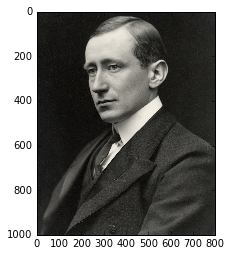

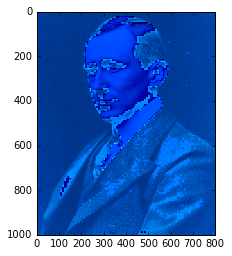

In [257]:
plt.imshow(image);plt.show()
plt.imshow(im)

In [ ]:
with gzip.open('file.gz', 'wb') as f:
    f.write(data.tobytes())

In [ ]:
with gzip.open('file2.gz', 'wb') as f:
    f.write(image.tobytes())

In [ ]:
print(utils.get_file_size('file.gz'))
print(utils.get_file_size('file2.gz'))
print(utils.get_file_size('images/calBlue.tiff'))

In [ ]:
with gzip.open('file.gz', 'rb') as f:
    file_content = f.read()

In [ ]:
a = np.fromstring(file_content,dtype = np.int16)

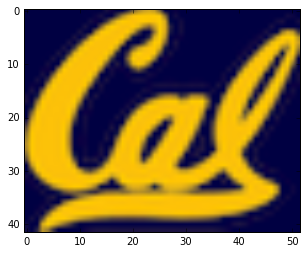

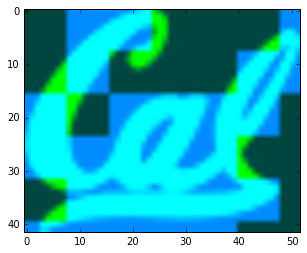

In [235]:
plt.imshow(image);plt.show()
plt.imshow(im)

In [ ]:
qs = range(1,99,5)
image = Marconi
psnrs = []
sizes = []
for quality in qs:
    data = JPEG_compression(image,quality)
    im = JPEG_decompression(data,quality,image.shape[0],image.shape[1])
    psnrs.append(utils.psnr(image,im))
    utils.save_to_gzip(data,"file")
    sizes.append(utils.get_file_size('file.gz'))


In [ ]:
plt.plot(qs,psnrs)
plt.xlabel("quality")
plt.ylabel("KBytes")
plt.figure()
plt.plot(qs,np.array(sizes)/1000)
plt.ylabel("KBytes")
plt.figure()
plt.plot(psnrs,np.array(sizes)/1000)

In [ ]:
quality = 50
image = createrLake

quality = 1
data = JPEG_compression(image,quality)
im1 = JPEG_decompression(data,quality,image.shape[0],image.shape[1])

quality = 10
data = JPEG_compression(image,quality)
im10 = JPEG_decompression(data,quality,image.shape[0],image.shape[1])

quality = 50
data = JPEG_compression(image,quality)
im50 = JPEG_decompression(data,quality,image.shape[0],image.shape[1])

print psnr(image, im1)
print psnr(image, im10)
print psnr(image, im50)